# **Cars 4 You | Machine Learning Project**

### **Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from rapidfuzz import process, fuzz


### **Import Data**

In [3]:
df = pd.read_csv('../Projeto/train.csv')

In [4]:
df_models = pd.read_csv('../Projeto/car_models.csv')

---

### **Data Understanding**

In [5]:
df.head()

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


In [6]:
df.describe(include='all')

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
count,75973.000000,74452,74456,74482.000000,75973.000000,74451,74510.000000,74462,68069.000000,68047.000000,74457.000000,74449.000000,74423.000000,74425.0
unique,NaN,72,735,NaN,NaN,40,NaN,34,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Ford,Focus,NaN,NaN,Manual,NaN,Petrol,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,14808,6353,NaN,NaN,38050,NaN,37995,NaN,NaN,NaN,NaN,NaN,NaN
mean,37986.000000,NaN,NaN,2017.096611,16881.889553,NaN,23004.184088,NaN,120.329078,55.152666,1.660136,64.590667,1.994580,0.0
std,21931.660338,NaN,NaN,2.208704,9736.926322,NaN,22129.788366,NaN,65.521176,16.497837,0.573462,21.021065,1.472981,0.0
min,0.000000,NaN,NaN,1970.000000,450.000000,NaN,-58540.574478,NaN,-91.121630,-43.421768,-0.103493,1.638913,-2.345650,0.0
25%,18993.000000,NaN,NaN,2016.000000,10200.000000,NaN,7423.250000,NaN,125.000000,46.300000,1.200000,47.000000,1.000000,0.0
50%,37986.000000,NaN,NaN,2017.000000,14699.000000,NaN,17300.000000,NaN,145.000000,54.300000,1.600000,65.000000,2.000000,0.0
75%,56979.000000,NaN,NaN,2019.000000,20950.000000,NaN,32427.500000,NaN,145.000000,62.800000,2.000000,82.000000,3.000000,0.0


#### **Data Quality**
- **Price**: we have outliers, since we have a really big jump from the 4th Quartile and the Max value and we have a slightly left skewed distribution
- **Mileage**: we have outliers, since we have a really big jump from the 4th Quartile and the Max value and we have a left skewed distribution, we also have negative values, so we need to handle these values
- **Tax**: we have negative values, we need to investigate why these values are negative and If they make any sense in this context
- **MPG**: We have negative values, we need to handle these values
- **Engine Size**: We have negative values, needing to handle them
- **PaintQuality%**: We have values above 100%, we need to check this cases and see if they make any kind of sense
- **previousOwners**: We have negative and float values, we need to handle this cases as well
- **hasDamage**: Seems like a constant value feature, we need to check if thats the case


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


In [8]:
# check for duplicates in car ID
df['carID'].nunique() == df.shape[0]

True

In [9]:
# check for duplicate rows
df.duplicated().sum()

np.int64(0)

---

## **Data Preparation**

#### **Checking for constant value features**

In [10]:
# check for constant values features
constant_features = [col for col in df.columns if df[col].nunique() == 1]
print(f'Constant features: {constant_features}')

Constant features: ['hasDamage']


Since hasDamage is a constant feature, we can safely remove it since theres no meaning if its keeped

In [11]:
df= df.drop(columns='hasDamage')

#### **Dealing with missing values**

First, lets check if we have any entries with every feature missing

In [12]:
# create a mask for rows where all columns except 'carID' and 'price' are NaN
mask = df.drop(columns=['carID', 'price']).isna().all(axis=1)
df_missing_rows = df[mask]

df_missing_rows.size

0

We don't have any row that is completely null

##### **Let's now check the percentages of missing values for each column**

In [13]:
# check the percentage of missing values for each column
missing_percent = df.isna().mean() * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)
df_missing_percent = pd.DataFrame({'column': missing_percent.index, 'missing_percent': missing_percent.values})
df_missing_percent

,column,missing_percent
0,mpg,10.432654
1,tax,10.403696
2,previousOwners,2.040198
3,paintQuality%,2.005976
4,transmission,2.003343
5,Brand,2.002027
6,model,1.996762
7,engineSize,1.995446
8,fuelType,1.988864
9,year,1.962539


We have some percentage of missing values but nothing too bad.

#### **Fill Missing Values in Numeric Features**

For the numeric features, we will use KNN imputation with the 5 nearest neighbors and just set the weights to 'uniform'.

In [14]:
num_cols = ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners']

In [15]:
# store mean and std
means = df[num_cols].mean()
stds = df[num_cols].std()

# normalize
df_scaled = (df[num_cols] - means) / stds

# impute on scaled data
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_imputed_scaled = pd.DataFrame(
    imputer.fit_transform(df_scaled),
    columns=num_cols,
    index=df.index
)

# inverse transform
df[num_cols] = df_imputed_scaled * stds + means

#### **Fill Missing Values in Categorical Features**

For the categorical variables we will use a Random Forest Classifier.  
We will train this RFC with the non null entries and use them to predict the null entries.  
We will do this sequentially in this order:  
Brand -> Model -> fuelType -> transmission

Since we believe thats the feature importance order.

In [16]:
def impute_categorical_rfc(df, target_col, ignore_cols=['carID', 'price'], n_estimators=200):
    """
    Impute missing values in a categorical column using a Random Forest Classifier.

    Parameters:
        df (pd.DataFrame): The dataframe containing missing values.
        target_col (str): Column to impute.
        ignore_cols (list): Columns to exclude from predictors.
        n_estimators (int): Number of trees for the Random Forest.

    Returns:
        pd.DataFrame: DataFrame with imputed column.
    """
    #split into rows with and without missing target
    df_notnull = df[df[target_col].notnull()]
    df_null = df[df[target_col].isnull()]

    #print(df_null.head())
    
    # predictors: list of all columns except target and ignored ones
    predictors = df.columns.drop([target_col] + ignore_cols)
    #print(predictors)
    
    #encode predictors, creates a column for every value of the target col and sets True/False for each row
    X_train = pd.get_dummies(df_notnull[predictors], drop_first=True)
    print(X_train)
    y_train = df_notnull[target_col]
    
    # train RFC
    rfc = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    rfc.fit(X_train, y_train)
    
    # predict missing
    if not df_null.empty:
        X_null = pd.get_dummies(df_null[predictors], drop_first=True)
        # we need to reindex the columns of X_null so we have the same columns as X_train
        # if therese a column in X_train that is not in X_null, we fill it with 0
        # if theres a column in X_null that is not in X_train, it will random guess
        X_null = X_null.reindex(columns=X_train.columns, fill_value=0)
        
        df.loc[df[target_col].isnull(), target_col] = rfc.predict(X_null)
    
    print(f"Imputed '{target_col}' using Random Forest with {len(X_train)} training rows.")
    return df

In [17]:
'''cat_cols = ['Brand', 'model', 'fuelType', 'transmission']

for col in cat_cols:
    df = impute_categorical_rfc(df, col)'''


"cat_cols = ['Brand', 'model', 'fuelType', 'transmission']\n\nfor col in cat_cols:\n    df = impute_categorical_rfc(df, col)"

In [18]:
# save the filled dataframe to a csv file
#df.to_csv('../data/filled_cars.csv', index=False)

In [19]:
df = pd.read_csv('../Projeto/filled_cars.csv')

---

### **Data Consistency**

**fixing brand and model typos**

In [20]:
# normalize strings: strip, lower
def clean_text(s):
    if pd.isna(s):
        return ''
    return str(s).strip().lower()

# normalize
df['brand_clean'] = df['Brand'].apply(clean_text)
df['model_clean'] = df['model'].apply(clean_text)
df_models['brand_clean'] = df_models['brand'].apply(clean_text)
df_models['model_clean'] = df_models['model'].apply(clean_text)
#print('Unique values for brand', df_models['brand_clean'].unique())


# --- fix models ---
def correct_model(row, df_models):
    model = row['model_clean']
    brand = row['brand_clean']
    
    if ((df_models['brand_clean'] == brand) & (df_models['model_clean'] == model)).any():
        return model
    
    if brand in df_models['brand_clean'].values:
        possible_models = df_models[df_models['brand_clean']==brand]['model_clean'].tolist()
        matched_model, score = safe_extract_one(model, possible_models, scorer=fuzz.ratio)
        return matched_model if score >= 40 else model
    
    possible_models = df_models['model_clean'].tolist()
    matched_model, score = safe_extract_one(model, possible_models, scorer=fuzz.ratio)
    return matched_model if score >= 40 else model

# --- fix brands ---
def correct_brand(row, df_models):
    brand = row['brand_clean']
    model = row['model_fixed']
    
    if brand in df_models['brand_clean'].values:
        return brand
    if model == 'unknown':
        return brand
    
    possible_brands = df_models[df_models['model_clean']==model]['brand_clean'].unique()
    #print("possible brands",possible_brands)
    if len(possible_brands) > 0:
        return possible_brands[0]
    
    all_brands = df_models['brand_clean'].unique()
    matched_brand, score = safe_extract_one(brand, all_brands, scorer=fuzz.token_sort_ratio)
    return matched_brand if score >= 40 else brand

# standard values in model
def standardize_model(s):
    if pd.isna(s):
        return ''
    s = str(s).lower().strip()
    s = s.replace('-', ' ')
    s = ' '.join(s.split())
    return s

def safe_extract_one(query, choices, scorer):
    result = process.extractOne(query, choices, scorer=scorer)
    if result is None:
        return None, 0
    # Algumas versões retornam 2 valores, outras 3
    if len(result) == 2:
        match, score = result
    elif len(result) == 3:
        match, score, _ = result
    else:
        match, score = result[0], result[1]
    return match, score



# standardize
df_models['model_clean'] = df_models['model'].apply(standardize_model)
df['model_clean'] = df['model'].apply(standardize_model)

# apply fix functions
df['model_fixed'] = df.apply(correct_model, axis=1, df_models=df_models)
df['brand_fixed'] = df.apply(correct_brand, axis=1, df_models=df_models)

# final resutl
df[['Brand', 'model', 'brand_fixed', 'model_fixed']]


# drop columns brand clean, model_clean, brand, model
df.drop(columns=['brand_clean', 'model_clean', 'Brand', 'model'], inplace= True)

df = df.rename(columns={'brand_fixed': 'brand', 'model_fixed': 'model'})

**fixing fuel type and transmission typos**

In [21]:
# Canonical values of fuel_type and transmission
canonical_fuels = ['petrol', 'diesel', 'hybrid', 'electric', 'other']
canonical_transmissions = ['manual', 'automatic', 'semi-auto', 'other']

# Normalize column strings
df['fuel_type_clean'] = (df['fuelType']
    .astype(str)
    .str.strip()
    .str.lower()
)
df['transmission_clean'] = (df['transmission']
    .astype(str)
    .str.strip()
    .str.lower()
)

# Correcting typos in the columns
def fuzzy_match_column(series, canonical_values, score_cutoff=85, default='other'):
    """
    Fuzzy-matches each value in a pandas Series to a list of canonical values.
    Example:
        fuzzy_match_column(df['fuel_type_clean'], ['petrol', 'diesel', 'electric'])
    """
    def match_one(value):


        # exact match
        if value in canonical_values:
            return value

        # fuzzy match
        match = process.extractOne(value, canonical_values, scorer=fuzz.token_sort_ratio)
        if match is None:
            return "unknown"

        best_choice, score, _ = match
        return best_choice if score >= score_cutoff else default

    return series.apply(match_one)


# apply fix functions
df['fuel_type_fixed'] = fuzzy_match_column(df['fuel_type_clean'], canonical_fuels)
df['transmission_fixed'] = fuzzy_match_column(df['transmission_clean'], canonical_transmissions)


# final result
df[['fuelType', 'fuel_type_clean', 'fuel_type_fixed',
    'transmission', 'transmission_clean', 'transmission_fixed']].head(10)


# drop and rename
df.drop(columns= ['fuelType', 'fuel_type_clean', 'transmission','transmission_clean'], inplace= True)

df = df.rename(columns={'fuel_type_fixed': 'fuel_type', 'transmission_fixed': 'transmission'})

### **Duplicates**

First thing first, lets check if we have duplicate ids

In [22]:
df['carID'][df['carID'].duplicated()]

Series([], Name: carID, dtype: int64)

AS we see, theres no duplicated ids

In [23]:
df[df.duplicated(keep=False)]

,carID,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,model,brand,fuel_type,transmission


No duplicated rows as well

### **Fix Column Names**

In [24]:
# change order of columns
df = df[['carID','brand', 'model', 'year', 'transmission', 'mileage', 'fuel_type', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'price']]

In [25]:
# rename column cardid to car_id and brand fixed to brand
df = df.rename(columns={'carID': 'car_id', 'engineSize': 'engine_size', 'paintQuality%': 'paint_quality', 'previousOwners': 'previous_owners'})

In [26]:
df.head()

,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
0,69512,volkswagen,golf,2016.0,semi-auto,28421.0,petrol,102.333851,11.417268,2.0,63.0,4.000000,22290
1,53000,toyota,yaris,2019.0,manual,4589.0,petrol,145.000000,47.900000,1.5,50.0,1.000000,13790
2,6366,audi,q3,2019.0,semi-auto,3624.0,petrol,145.000000,40.900000,1.5,56.0,4.000000,24990
3,29021,ford,fiesta,2018.0,manual,9102.0,petrol,145.000000,65.700000,1.0,50.0,-2.340306,12500
4,10062,bmw,2 series,2019.0,manual,1000.0,petrol,145.000000,42.800000,1.5,97.0,3.000000,22995


### **Fix Negative Values**

In [27]:
columns_negative= ["previous_owners","mileage","mpg","engine_size","tax"]

# Apply abs function to each column in columns_negative
for col in columns_negative:
    df[col] = df[col].abs()

In [28]:
df[['mileage','paint_quality','year','previous_owners']] = (
    df[['mileage','paint_quality','year','previous_owners']]
    .round()
    .astype('Int64')   # allows missing values
)

In [29]:
df[['tax', 'mpg']] = df[['tax', 'mpg']].round(2)

---

### **Outliers**

KeyError: 'engineSize'

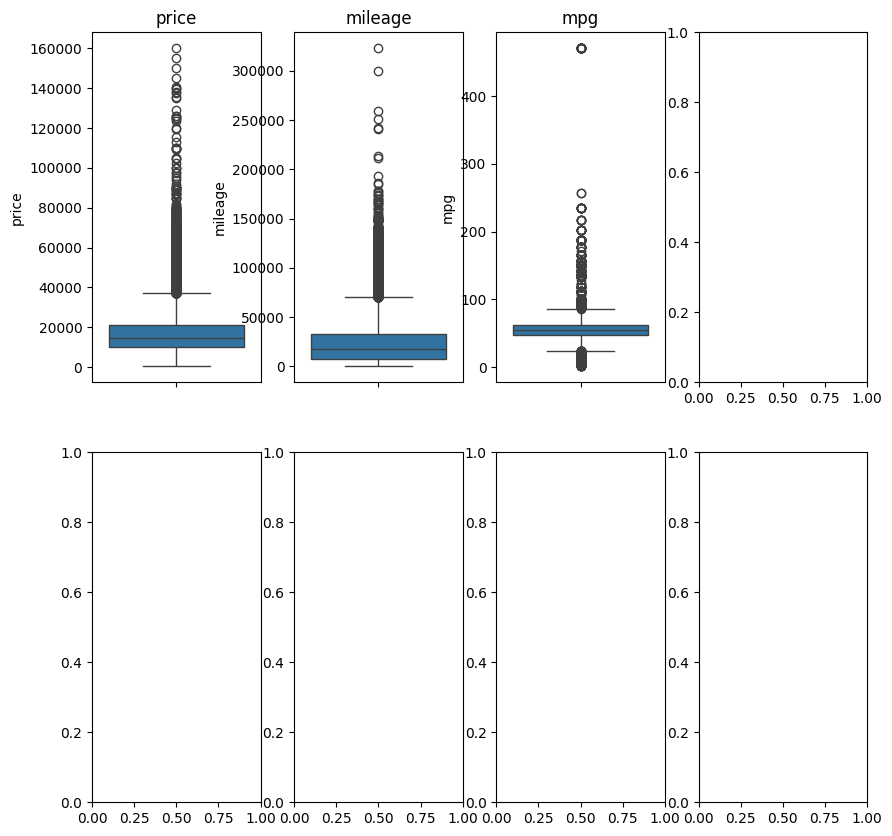

In [30]:
fig, axes = plt.subplots(2, 4, figsize=(10, 10))
axes = axes.flatten()  # makes it a 1D array of length 6

sns.boxplot(df["price"], ax=axes[0])
axes[0].set_title("price")

sns.boxplot(df["mileage"], ax=axes[1])
axes[1].set_title("mileage")

sns.boxplot(df["mpg"], ax=axes[2])
axes[2].set_title("mpg")

sns.boxplot(df["engineSize"], ax=axes[3])
axes[3].set_title("engineSize")

sns.boxplot(df["year"], ax=axes[4])
axes[4].set_title("year")

sns.boxplot(df["paintQuality%"], ax=axes[5])
axes[5].set_title("paintQuality%")

sns.boxplot(df["previousOwners"], ax=axes[6])
axes[6].set_title("previousOwners")

plt.tight_layout()
plt.show()

1️⃣ price 

Observations: Most cars are clustered below ~40,000£, but there are numerous outliers above 50,000£, some exceeding 160,000£.
Interpretation: The dataset includes luxury or rare cars that are not typical — a right-skewed distribution.
Actionable insight:
Outliers may affect models sensitive to scale (like linear regression).
Could consider log-transforming price for regression models.
If predicting typical cars, consider capping extreme values or modeling separately.

2️⃣ mileage (miles traveled)
Observations: Majority of cars have mileage between ~5,000–50,000 miles. Some extreme high-mileage cars exceed 200,000 miles.
Interpretation: High-mileage cars are rare but present — right-skewed.
Insights:Could indicate older cars or heavy usage vehicles.
Extreme mileage outliers might distort models — consider log-transform or robust scaling.

3️⃣ mpg (Average Miles per Gallon)
Observations: Most cars cluster between 20–60 mpg, but some extreme outliers go above 400 mpg — likely data entry errors.
Insights:Values above ~100 mpg are unrealistic for standard cars → should be investigated and corrected or removed.
Could affect predictive modeling for fuel efficiency or price.

4️⃣ engineSize (liters)
Observations: Majority of engines are 1–3 liters. Outliers go beyond 5–6 liters.
Insights:Large engines (>5 L) are rare sports or luxury cars — aligns with high price outliers.
Outliers might be genuine, but check for misrecorded units.

5️⃣ year (Registration Year)
Observations: Most cars registered after 2005. Outliers below 1980, including one car around 1970.
Insights:Very old cars may be classic/collector cars → likely to have high price.
Could treat year as a numeric or categorical feature (modern vs. old cars) depending on the model.

6️⃣ paintQuality%
Observations: Values roughly span 0–125%, with most between 40–100%.
Could be a strong predictor of price or likelihood of damage.

7️⃣ previousOwners
Observations: Most cars have 1–3 previous owners. Few outliers have 6+ owners.
Insights:High owner counts are rare and could affect depreciation analysis.
Could treat as categorical or cap outliers at a reasonable max (e.g., 5).

## **EDA (Exploratory Data Analysis)**

### **Numerical Distributions**

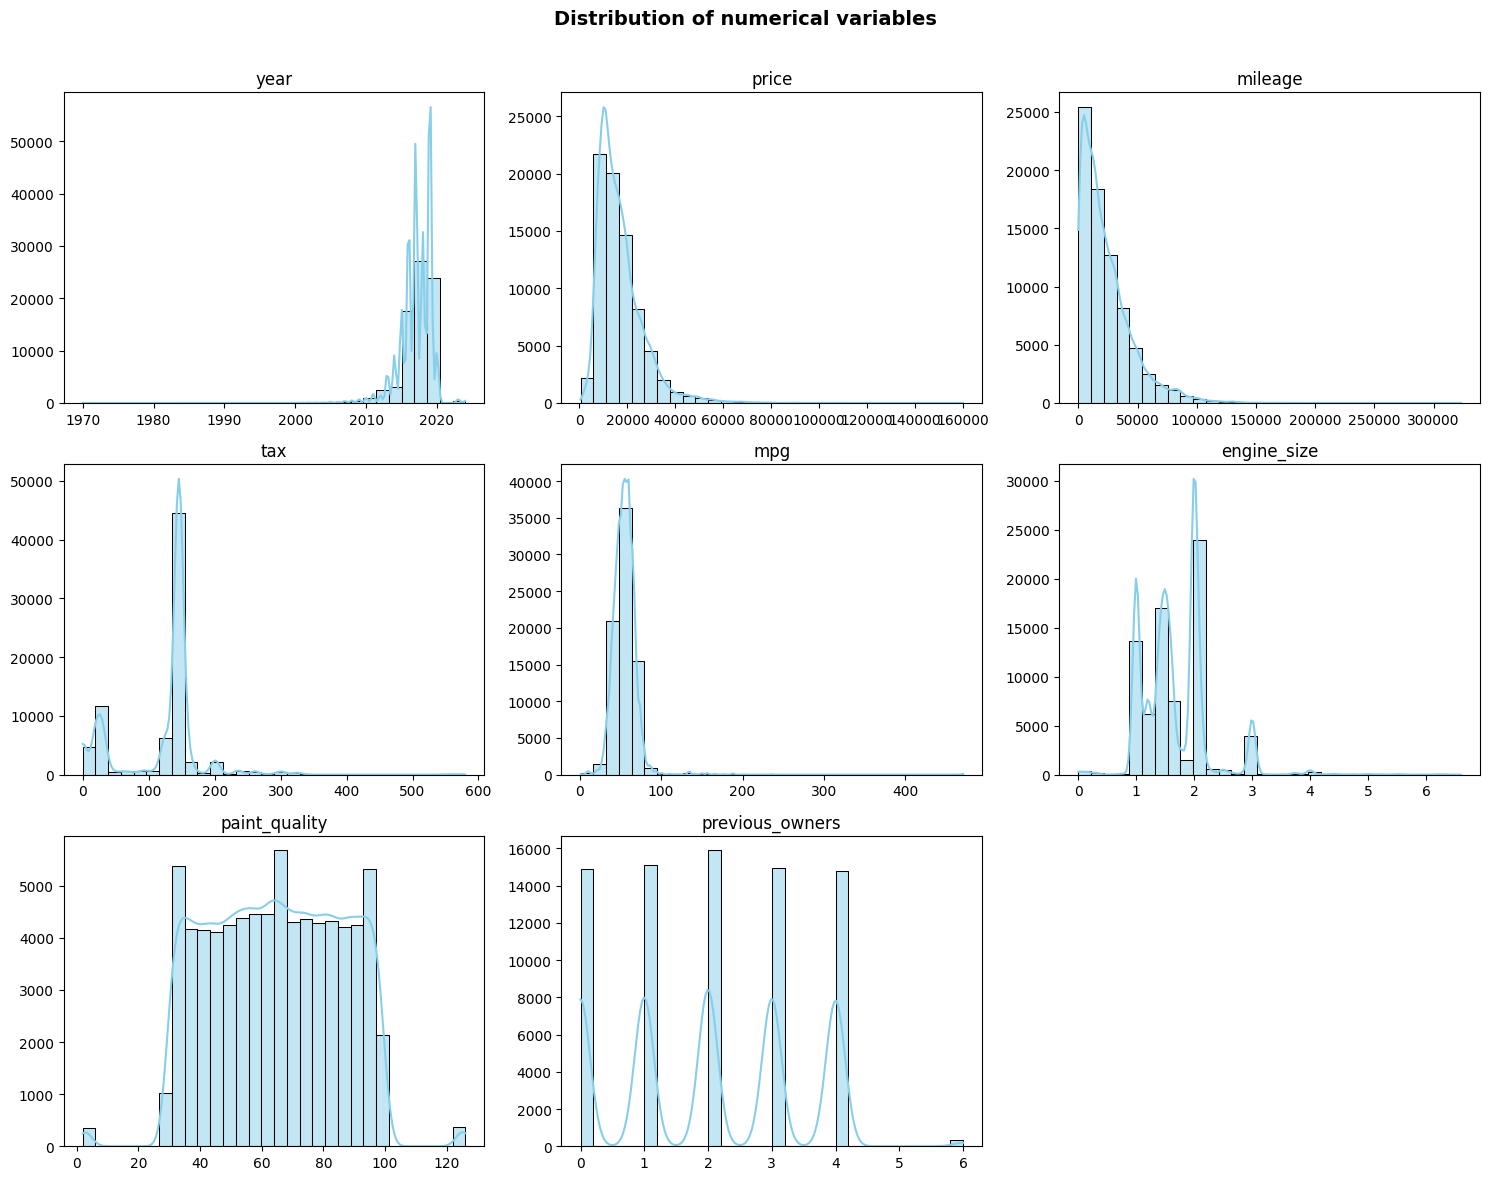

In [31]:
num_cols = [c for c in ['year','price','mileage','tax','mpg','engine_size','paint_quality','previous_owners'] if c in df.columns]

n = len(num_cols)
ncols = 3  # number of graphics per row
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4*nrows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

#remove empty axes (if number of plots is not a multiple of ncols)--» otherwise there would be an empty graph in the third line
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution of numerical variables", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()



1️⃣**Year**

**Shape:** Unimodal and sharply concentrated in recent years, with a short left tail.

**Central Tendency:** Most cars are from 2016–2020, with a clear density peak around 2018.

**Range:** Extends from around 2000 to 2024, with few older vehicles.

**Implication:** The dataset is dominated by modern vehicles, which likely correlates positively with price. Creating a derived “car age” feature could better capture the depreciation effect.


2️⃣ **Price**

**Shape:** Unimodal and strongly right-skewed, with a long upper tail.

**Central Tendency:** The majority of cars are priced between €10,000 and €20,000..

**Range:** Spans from about €500 to €160,000, revealing clear outliers at the high end.

**Implication:** The distribution shows substantial skewness. A log transformation (log1p) could stabilize variance and make relationships with predictors more linear.


3️⃣ **Mileage**

**Shape:** Right-skewed, with most cars having low mileage and a gradual decrease toward higher values.

**Central Tendency:** Highest density occurs between 0 and 40,000 km, after which frequency steadily declines.

**Range:** From 0 to over 300,000 km — a wide spread typical of both new and used cars.

**Implication:** Mileage now behaves logically after removing invalid negatives. Expected to be negatively correlated with price, reflecting vehicle usage and wear.


4️⃣**Tax**

**Shape:** Highly right-skewed, with most values clustered around a specific tax band.

**Central Tendency**: Clear concentration around 150–200, with smaller peaks near 0–50.

**Range:** From 0 to nearly 600, with a few extreme outliers.

**Implication:** The majority of cars fall within standard tax brackets, but the presence of low and zero values may require validation — these could represent missing or exempt vehicles.


5️⃣**MPG**

**Shape:** Strongly right-skewed, concentrated within a narrow range and a long upper tail.

**Central Tendency:** Most cars have 40–80 MPG, indicating generally efficient vehicles.

**Range:** Extends from around 0 up to 450, with extremely high values that are likely outliers or recording errors.

**Implication:** The feature is meaningful for efficiency analysis, but extreme values should be reviewed or capped. A log transformation could help handle the skewness.




6️⃣**Engine Size**

**Shape:** Multimodal, with multiple distinct peaks around 1.0, 1.6, and 2.0 liters.

**Central Tendency:** Most cars fall between 1.0 and 2.0 L, representing common engine capacities.

**Range:** From 0 to around 6.5 L, with a few large-engine outliers.

**Implication:** The multimodal pattern suggests a mix of small, mid-size, and high-performance vehicles. It is likely positively correlated with price, reflecting engine power and vehicle class.


7️⃣**Paint Quality**

**Shape:** Roughly uniform, though slightly uneven across the range, with occasional spikes.

**Central Tendency:** Values are widely distributed between 30 and 90, showing no clear dominant level.

**Range:** Extends from around 0 to 120, exceeding the expected 0–100 scale.

**Implication:** The near-uniform distribution suggests this variable may have limited predictive power for price. Values above 100 should be reviewed, as they likely indicate measurement or input errors.


8️⃣**Previous Owners**

**Shape:** Discrete and multimodal, with clear peaks at each integer value (0–4).

**Central Tendency:** Most cars have between 0 and 4 previous owners, with counts fairly balanced across these categories.

**Range:** From 0 to about 6, with few cases above 4.

**Implication:** The stepwise pattern is expected for a count variable. Higher numbers of owners may negatively impact price, but the relatively even distribution suggests this effect might be moderate.


### **Numerical Variables — Correlation and Impact on Price**

#### **Scatterplots**

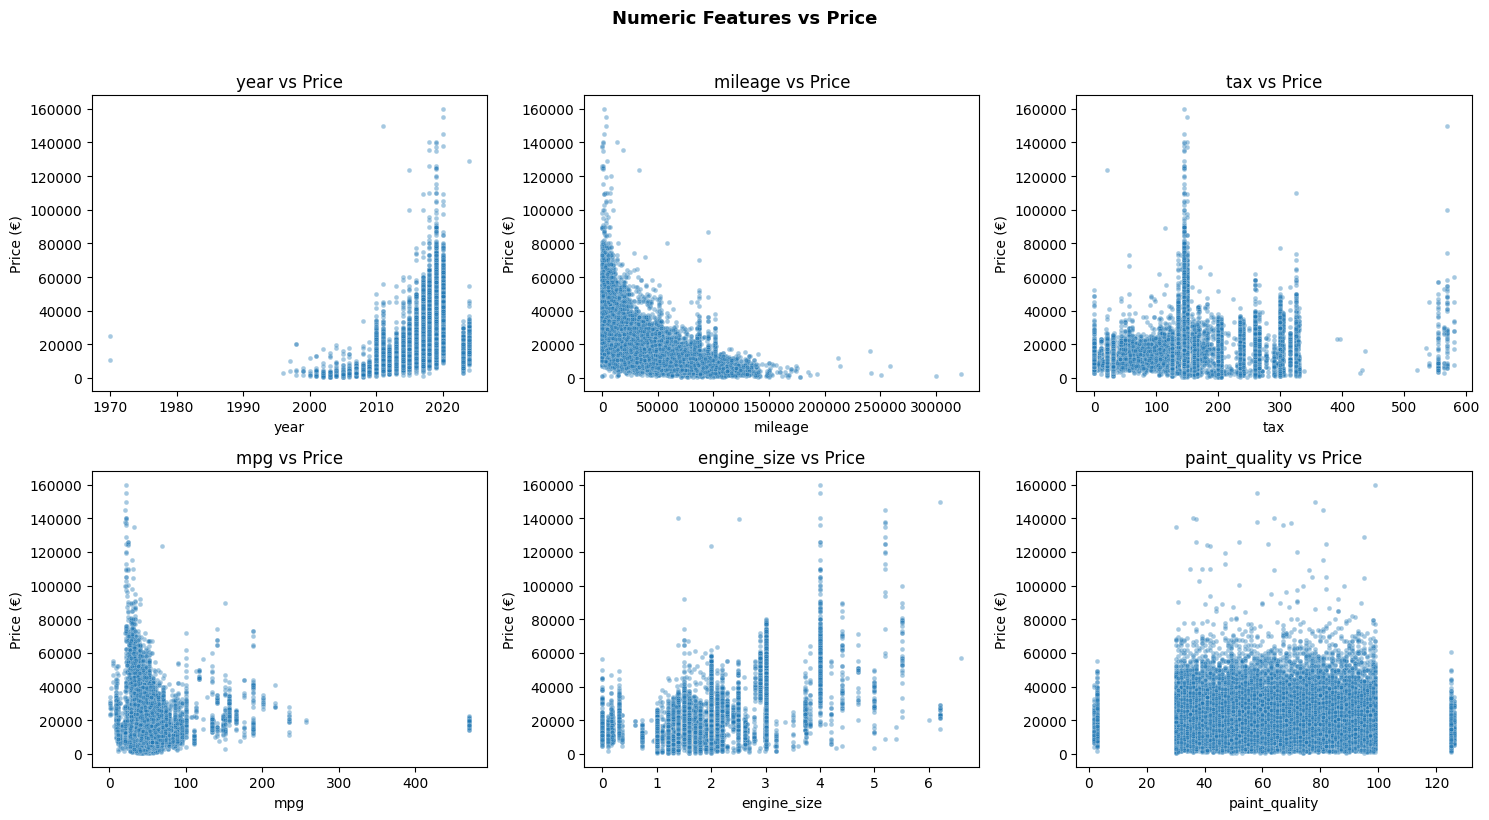

<Figure size 640x480 with 0 Axes>

In [32]:
# List of the numerical features
num_cols = ['year', 'mileage', 'tax', 'mpg', 'engine_size', 'paint_quality', 'previous_owners', 'price']

# Scatterplots for all the numerical features except "previous_owners" because it doesn´t make sense to use scaterplott in this variable
others = [c for c in num_cols if c not in ['price', 'previous_owners']]
n, ncols = len(others), 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4*nrows))
axes = np.array(axes).reshape(-1)

for ax, col in zip(axes, others):
    sns.scatterplot(data=df, x=col, y='price', alpha=0.4, s=12, ax=ax)
    ax.set_title(f"{col} vs Price")
    ax.set_xlabel(col)
    ax.set_ylabel("Price (€)")

# Remove eixos vazios se existirem
for j in range(len(others), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Numeric Features vs Price", y=1.02, fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()
plt.tight_layout(); plt.show()

**year → price**

Clear positive relationship: newer cars tend to be more expensive.

Vertical banding by year is expected (year is discrete).

**Tip:** Consider using car age = ref_year − year. Likely one of the most informative features.


**mileage → price**

Strong negative trend: higher mileage → lower price.

Relationship looks non-linear (steeper drop at low mileage, flattens later).

**Tip:** Try log(mileage) (after fixing zeros) or spline/GBM to capture the curve.

**engine_size → price**

Positive but noisy association.

Multiple vertical stripes (common engine sizes: 1.0, 1.6, 2.0, 3.0…).

**Tip:** Keep it; effect may strengthen when interacting with brand/model.

**mpg → price**

Weak/ambiguous overall pattern; hints of negative association (efficient cars often cheaper than high-performance ones).

Also shows discrete bands (recording conventions).

**Tip:** Expect low-to-moderate importance; may become clearer after controlling for engine_size/brand.

**tax → price**

No clean trend; values cluster in regulatory bands.

Likely low standalone predictive power; may carry signal only via interaction with engine_size / emissions / year.

**paint_quality → price**

Cloud with no visible trend; near-uniform vertical spread.

Likely little to no effect on price (as recorded).

**Tip:** Candidate to drop or keep only after capping to valid range (0–100).

**🎯 Quick takeaways (useful vs. not useful)**

**Likely useful:** year (or age), mileage, engine_size.

**Possibly useful (context/interaction):** mpg, tax

**Low utility as-is:** paint_quality.

C:\Users\Monica\AppData\Local\Temp\ipykernel_7336\2792255685.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=median_price.index, y=median_price.values, palette="magma")


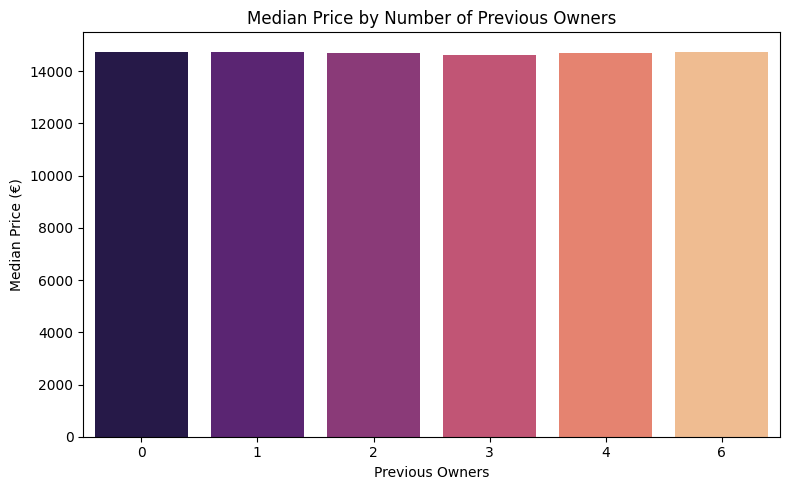

In [33]:
# Bar chart for previous_owners (we use the median price because it better represents the typical car price, since it is less affected by outliers than the mean.)
plt.figure(figsize=(8,5))
median_price = df.groupby('previous_owners')['price'].median().sort_index()
sns.barplot(x=median_price.index, y=median_price.values, palette="magma")
plt.title("Median Price by Number of Previous Owners")
plt.xlabel("Previous Owners")
plt.ylabel("Median Price (€)")
plt.tight_layout()
plt.show()

The median price remains almost constant across different numbers of previous owners, indicating that ownership history has little to no direct impact on price.

#### **Correlation Matrix**

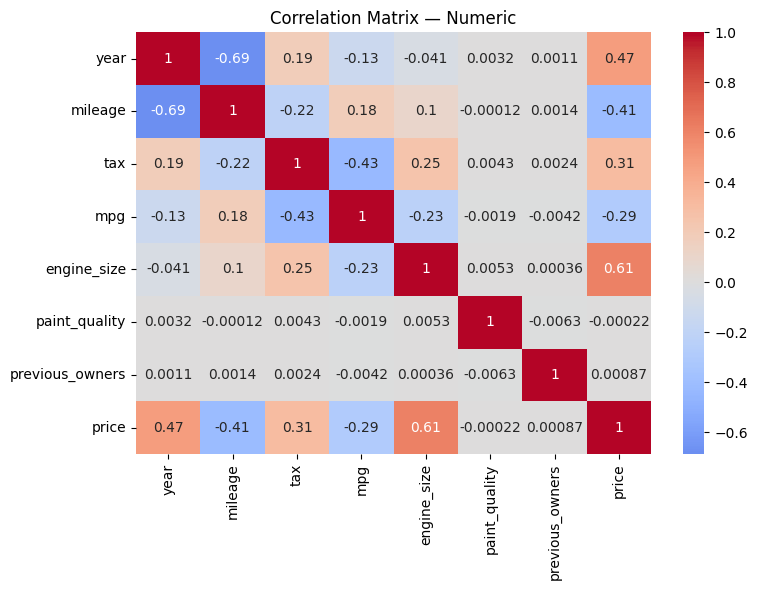

In [34]:
corr = df[num_cols].corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix — Numeric"); plt.tight_layout(); plt.show()

**📊 Correlation Insights**

1. Price is positively correlated with year (0.47) and engine_size (0.61) — newer cars and larger engines tend to be more expensive.

2. Mileage shows a moderate negative correlation (−0.41) with price — higher mileage reduces car value.

3. Other variables (tax, mpg, paint_quality, previous_owners) have weak or negligible correlations, suggesting low direct impact on price.

4. Year and mileage are strongly negatively correlated (−0.69), which makes sense: newer cars usually have fewer kilometers.

#### **Price correlation ranking**

### **Categorical Features vs Price**

C:\Users\Monica\AppData\Local\Temp\ipykernel_7336\3819430706.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price.index, y=avg_price.values, palette="viridis")


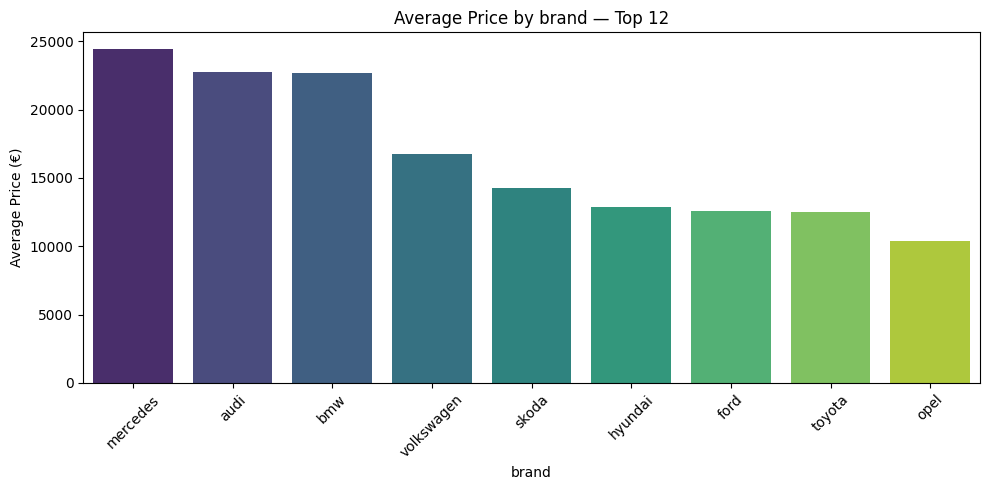

C:\Users\Monica\AppData\Local\Temp\ipykernel_7336\3819430706.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price.index, y=avg_price.values, palette="viridis")


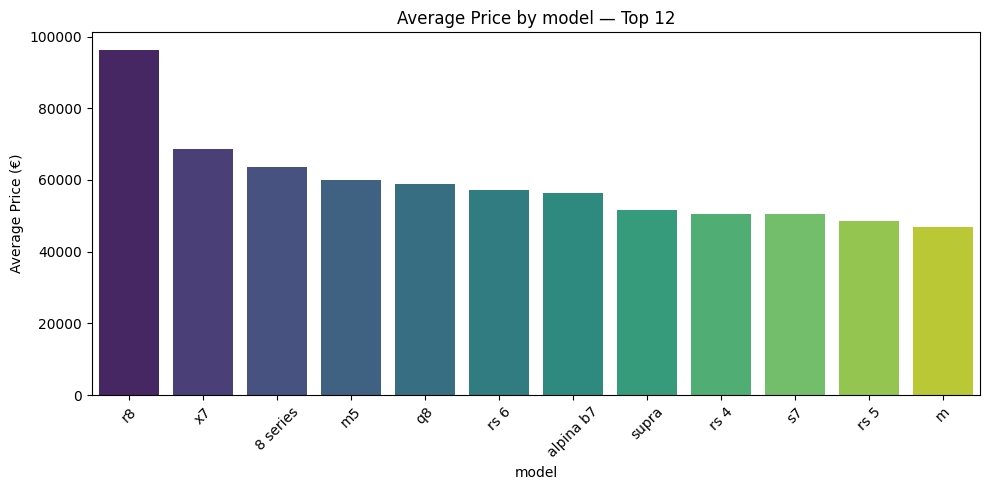

C:\Users\Monica\AppData\Local\Temp\ipykernel_7336\3819430706.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price.index, y=avg_price.values, palette="viridis")


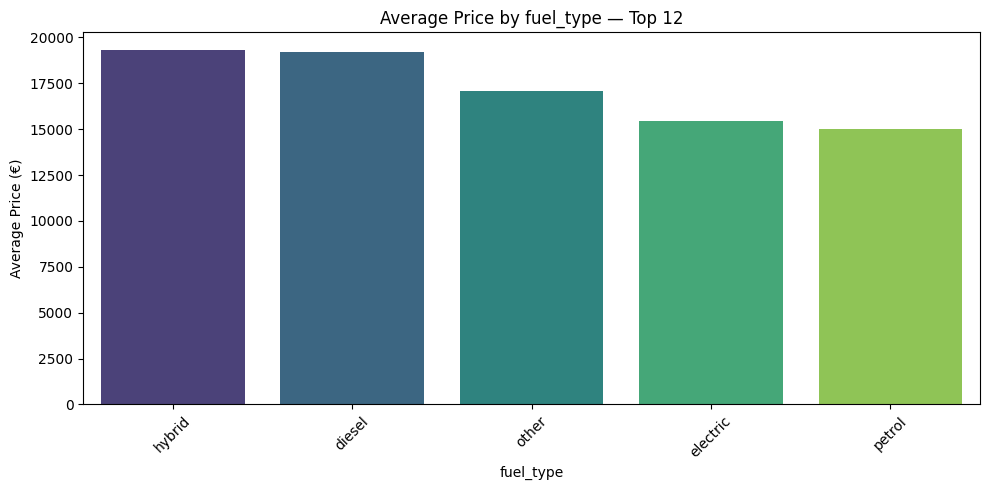

C:\Users\Monica\AppData\Local\Temp\ipykernel_7336\3819430706.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price.index, y=avg_price.values, palette="viridis")


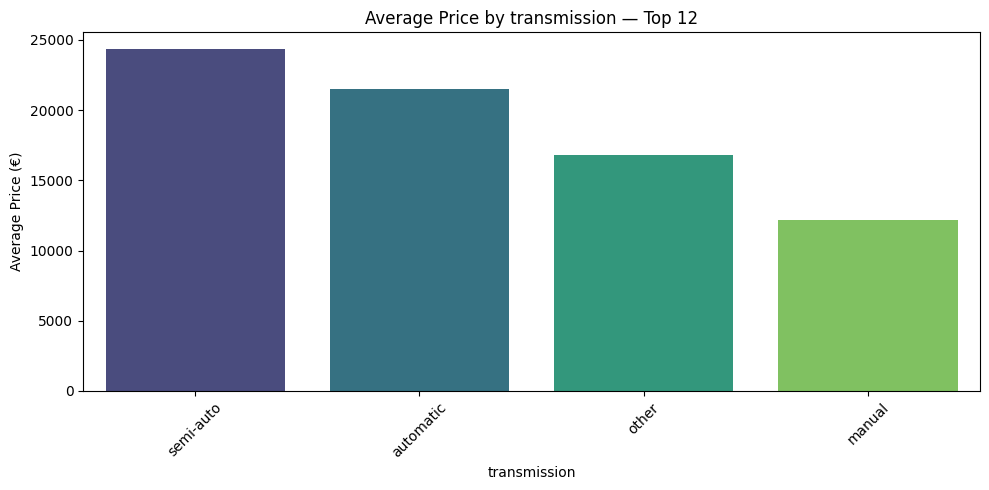

In [35]:
cat_cols = [c for c in ['brand','model','fuel_type','transmission'] if c in df.columns]
TOP_N = 12

for col in cat_cols:
    plt.figure(figsize=(10,5))
    #Calculate the average price per category and select the top N
    avg_price = df.groupby(col)['price'].mean().sort_values(ascending=False).head(TOP_N)
    
    sns.barplot(x=avg_price.index, y=avg_price.values, palette="viridis")
    plt.title(f"Average Price by {col} — Top {TOP_N}")
    plt.xlabel(col)
    plt.ylabel("Average Price (€)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



**Brand**

Luxury brands such as Mercedes, Audi, and BMW clearly dominate the top of the price range.

These brands have average prices almost double those of mid-range ones like Skoda, Ford, or Opel.

➡️ Strong influence on price — brand is a key predictor of vehicle value.

**Model**

Premium or performance-oriented models (i8, X7, 8 series, M5) have much higher average prices.

The price gap between top and lower models exceeds €70K, showing significant variance within the same brand.

➡️ Model captures fine-grained distinctions within brands — very important feature for prediction.

**Fuel Type**

Hybrid and diesel cars tend to be more expensive than petrol or electric ones.

Electric cars’ lower mean price may reflect smaller or older EVs in the dataset.

➡️ Fuel type has moderate impact — differences are visible but not extreme.

**Transmission**

Semi-automatic and automatic cars show higher average prices than manual ones.

Likely reflects modern / high-end models using automatic systems.

➡️ Transmission has a clear positive effect on price — useful categorical variable.

C:\Users\Monica\AppData\Local\Temp\ipykernel_7336\1049514656.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=median_price.index, y=median_price.values, palette="viridis")


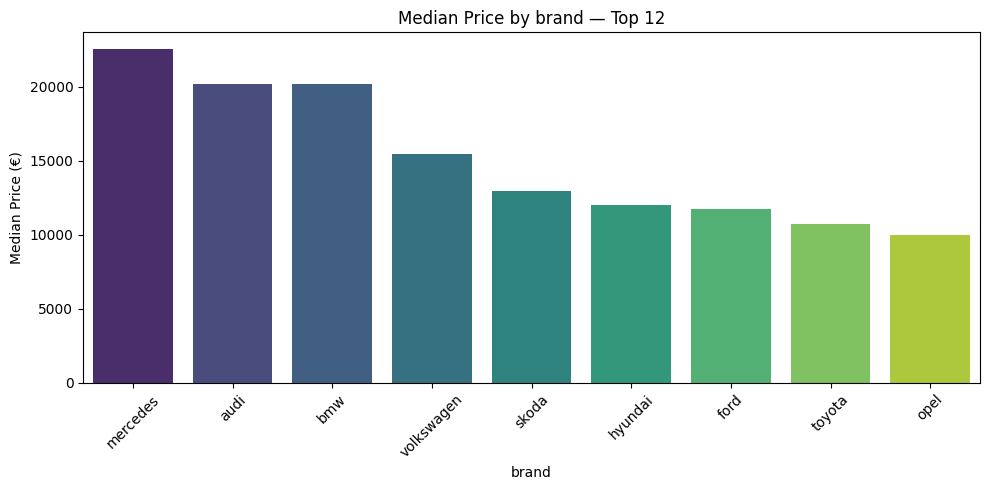

C:\Users\Monica\AppData\Local\Temp\ipykernel_7336\1049514656.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=median_price.index, y=median_price.values, palette="viridis")


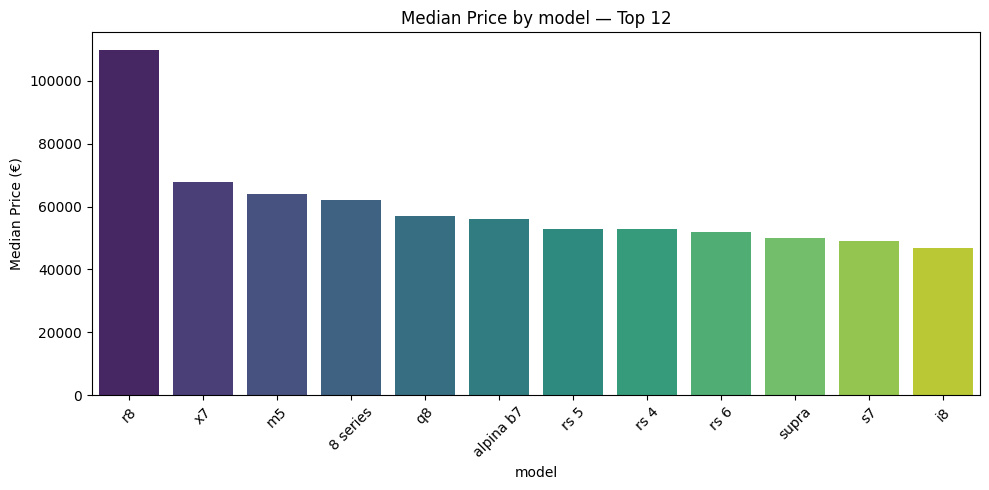

C:\Users\Monica\AppData\Local\Temp\ipykernel_7336\1049514656.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=median_price.index, y=median_price.values, palette="viridis")


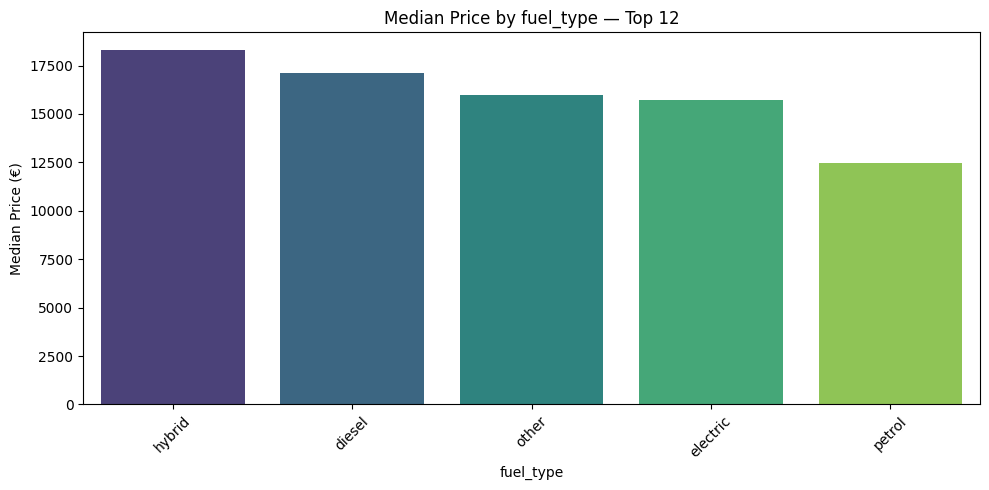

C:\Users\Monica\AppData\Local\Temp\ipykernel_7336\1049514656.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=median_price.index, y=median_price.values, palette="viridis")


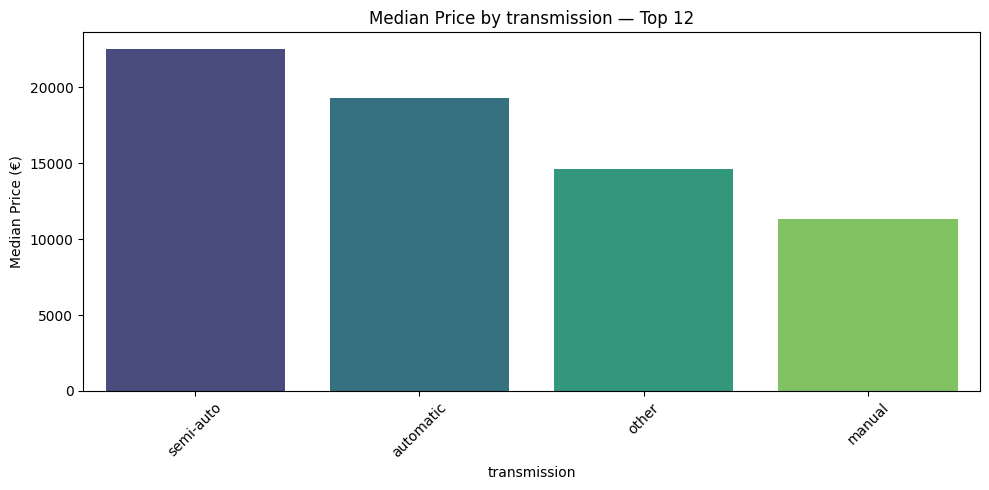

In [37]:
cat_cols = [c for c in ['brand','model','fuel_type','transmission'] if c in df.columns]
TOP_N = 12

for col in cat_cols:
    plt.figure(figsize=(10,5))
    # Calculate the median price per category and select the top N
    median_price = df.groupby(col)['price'].median().sort_values(ascending=False).head(TOP_N)
    
    sns.barplot(x=median_price.index, y=median_price.values, palette="viridis")
    plt.title(f"Median Price by {col} — Top {TOP_N}")
    plt.xlabel(col)
    plt.ylabel("Median Price (€)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## **Encoding**

**fuel_type (5 categories)** → One-Hot Encoding (OHE)

**brand (9 categories)** → One-Hot Encoding (OHE)

**transmission (4 categories)** → One-Hot Encoding (OHE)

**model (10 + categories)** → Target Encoding with K-Fold (pre defined)


In [103]:
# 1st step: Create a copy of the original df
df_encoded = df.copy()


In [104]:
#The brand variable was transformed using One-Hot Encoding, creating one binary column per brand (1 if the car belongs to that brand, 0 otherwise).
#It creates this columns: brand_volkswagen, brand_toyota, brand_audi, brand_hyundai,etc

# One-Hot Encoding for brand
brand_dummies = pd.get_dummies(df['brand'], prefix='brand', drop_first=False).astype(int)
df_encoded = pd.concat([df_encoded, brand_dummies], axis=1)

df_encoded.head()


,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,...,price,brand_audi,brand_bmw,brand_ford,brand_hyundai,brand_mercedes,brand_opel,brand_skoda,brand_toyota,brand_volkswagen
0,69512,volkswagen,golf,2016,semi-auto,28421,petrol,102.33,11.42,2.0,...,22290,0,0,0,0,0,0,0,0,1
1,53000,toyota,yaris,2019,manual,4589,petrol,145.00,47.90,1.5,...,13790,0,0,0,0,0,0,0,1,0
2,6366,audi,q3,2019,semi-auto,3624,petrol,145.00,40.90,1.5,...,24990,1,0,0,0,0,0,0,0,0
3,29021,ford,fiesta,2018,manual,9102,petrol,145.00,65.70,1.0,...,12500,0,0,1,0,0,0,0,0,0
4,10062,bmw,2 series,2019,manual,1000,petrol,145.00,42.80,1.5,...,22995,0,1,0,0,0,0,0,0,0


In [105]:
# One-Hot Encoding for fuel_type
#It creates the columns: fuel_petrol, fuel_diesel, fuel_hybrid, fuel_electric, fuel_other
fuel_dummies = pd.get_dummies(df['fuel_type'], prefix='fuel', drop_first=False).astype(int)
df_encoded = pd.concat([df_encoded, fuel_dummies], axis=1)

df_encoded.head()


,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,...,brand_mercedes,brand_opel,brand_skoda,brand_toyota,brand_volkswagen,fuel_diesel,fuel_electric,fuel_hybrid,fuel_other,fuel_petrol
0,69512,volkswagen,golf,2016,semi-auto,28421,petrol,102.33,11.42,2.0,...,0,0,0,0,1,0,0,0,0,1
1,53000,toyota,yaris,2019,manual,4589,petrol,145.00,47.90,1.5,...,0,0,0,1,0,0,0,0,0,1
2,6366,audi,q3,2019,semi-auto,3624,petrol,145.00,40.90,1.5,...,0,0,0,0,0,0,0,0,0,1
3,29021,ford,fiesta,2018,manual,9102,petrol,145.00,65.70,1.0,...,0,0,0,0,0,0,0,0,0,1
4,10062,bmw,2 series,2019,manual,1000,petrol,145.00,42.80,1.5,...,0,0,0,0,0,0,0,0,0,1


In [98]:
# One-Hot Encoding for transmission
#it creates the columns: trans_manual, trans_automatic, trans_semi-auto, trans_other

trans_dummies = pd.get_dummies(df['transmission'], prefix='trans', drop_first=False).astype(int)
df_encoded = pd.concat([df_encoded, trans_dummies], axis=1)

df_encoded.head()

,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,...,price,fuel_diesel,fuel_electric,fuel_hybrid,fuel_other,fuel_petrol,trans_automatic,trans_manual,trans_other,trans_semi-auto
0,69512,volkswagen,golf,2016,semi-auto,28421,petrol,102.33,11.42,2.0,...,22290,0,0,0,0,1,0,0,0,1
1,53000,toyota,yaris,2019,manual,4589,petrol,145.00,47.90,1.5,...,13790,0,0,0,0,1,0,1,0,0
2,6366,audi,q3,2019,semi-auto,3624,petrol,145.00,40.90,1.5,...,24990,0,0,0,0,1,0,0,0,1
3,29021,ford,fiesta,2018,manual,9102,petrol,145.00,65.70,1.0,...,12500,0,0,0,0,1,0,1,0,0
4,10062,bmw,2 series,2019,manual,1000,petrol,145.00,42.80,1.5,...,22995,0,0,0,0,1,0,1,0,0


In [106]:
#"model" has a lot of categories so if we used OHE it would creat 100+ columns and we don´t want that 
#The best option is Target Encoding (it has a direct relationship with the target (price))
#This type of encoding uses the average of the price per model to represent that relationship directly 

from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split

# Creats copies for train and validation
df_te = df.copy()
X = df_te.drop(columns=['price'])
y = df_te['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplies Target Encoding ONLY on training (to avoid data leakage!)
te = TargetEncoder(cols=['model'])
X_train['model_te'] = te.fit_transform(X_train['model'], y_train) 
X_val['model_te'] = te.transform(X_val['model'])

# It removes the original column 'model' 
X_train = X_train.drop(columns=['model'])
X_val = X_val.drop(columns=['model'])

#Target Encoding applied to the complete dataset (with encoder already trained)
df_encoded['model_te'] = te.transform(df_encoded['model']).round(2)




In [107]:
#Now lets drop all the original columns
df_encoded = df_encoded.drop(columns=['fuel_type', 'brand', 'transmission', 'model'])

In [108]:
df_encoded.head()

,car_id,year,mileage,tax,mpg,engine_size,paint_quality,previous_owners,price,brand_audi,...,brand_opel,brand_skoda,brand_toyota,brand_volkswagen,fuel_diesel,fuel_electric,fuel_hybrid,fuel_other,fuel_petrol,model_te
0,69512,2016,28421,102.33,11.42,2.0,63,4,22290,0,...,0,0,0,1,0,0,0,0,1,16585.14
1,53000,2019,4589,145.00,47.90,1.5,50,1,13790,0,...,0,0,1,0,0,0,0,0,1,10975.39
2,6366,2019,3624,145.00,40.90,1.5,56,4,24990,1,...,0,0,0,0,0,0,0,0,1,23163.48
3,29021,2018,9102,145.00,65.70,1.0,50,2,12500,0,...,0,0,0,0,0,0,0,0,1,10245.68
4,10062,2019,1000,145.00,42.80,1.5,97,3,22995,0,...,0,0,0,0,0,0,0,0,1,19873.88


In [ ]:
df_encoded.columns